In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
init_dataset_path = 'drive/MyDrive/MNIST/' + 'train-images.idx3-ubyte'
init_queryset_path = 'drive/MyDrive/MNIST/' + 't10k-images-idx3-ubyte'
output_dataset_path = 'drive/MyDrive/MNIST/' + 'output_dataset_file.bin'
output_queryset_path = 'drive/MyDrive/MNIST/' + 'output_queryset_file.bin'

In [3]:
import struct
import numpy as np
from sklearn.model_selection import train_test_split

import os

current_path = os.getcwd()
print("Current Working Directory:", current_path)

def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        image_data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return image_data

def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        label_data = np.frombuffer(f.read(), dtype=np.uint8)
    return label_data

# Replace 'path_to_mnist_files' with the path to your MNIST dataset files
path_to_mnist_files = 'drive/MyDrive/MNIST/'

# Read training set
train_images = read_mnist_images(init_dataset_path)

# Read test set
test_images = read_mnist_images(init_queryset_path)

# Now you have the MNIST dataset loaded into NumPy arrays: train_images, test_images
print(train_images.shape)
print(test_images.shape)

x_train, x_valid = train_test_split(train_images, test_size=0.2, random_state=42)

x_train = x_train.astype('float32') / 255.
x_valid = x_valid.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_valid = np.reshape(x_valid, (len(x_valid), 28, 28, 1))


x_test = test_images.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)



Current Working Directory: /content
(60000, 28, 28)
(10000, 28, 28)
(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


# Model training

In [ ]:
from logging import basicConfig
import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

# This is the size of our encoded representations
import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from keras.models import Model
from tensorflow.keras import backend as K

# This is the size of our encoded representations
original_dim = 28 * 28
latent_dim = 30

batch_size = 128
epoch = 20

print(f'Compression factor: {original_dim / latent_dim}')

input_img = keras.Input(shape=(28, 28, 1))


x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x_1 = layers.MaxPooling2D((2, 2), padding='same')(x)
x_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x_1)
x_3 = layers.MaxPooling2D((2, 2), padding='same')(x_2)
encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x_3)
print(encoded.shape)

volumeSize = K.int_shape(encoded)
# Downsampling to latent dimension
flattened_encoded = layers.Flatten()(encoded)
dense_layer = layers.Dense(latent_dim, activation='relu')(flattened_encoded)
encoder_model = Model(input_img, dense_layer)

# HERE THE ENCODER ENDS, output in latent dimension

latent_img_dim = keras.Input(shape=(latent_dim,))
# HERE DECODER STARTS, WITH THE RECONSTRUCTION
print(np.prod(volumeSize[1:]))
y = layers.Dense(np.prod(volumeSize[1:]))(latent_img_dim)
y_1 = layers.Reshape((volumeSize[1],volumeSize[2],volumeSize[3]))(y)
print(y.shape)
y_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(y_1)
y_3 = layers.UpSampling2D((2, 2))(y_2)
y_4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(y_3)
y_5 = layers.UpSampling2D((2, 2))(y_4)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y_5)

decoder_model = Model(latent_img_dim, decoded)

output = decoder_model(encoder_model(input_img))
basic = Model(input_img, output)
basic.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_train = basic.fit(x_train, x_train, batch_size=batch_size, epochs=epoch,
                                     verbose=1, validation_data=(x_valid, x_valid))

Compression factor: 26.133333333333333
(None, 7, 7, 128)
6272
(None, 6272)
Epoch 1/20
375/375 [==============================] - 362s 951ms/step - loss: 0.1797 - val_loss: 0.1252
Epoch 2/20
375/375 [==============================] - 364s 971ms/step - loss: 0.1152 - val_loss: 0.1094
Epoch 3/20
375/375 [==============================] - 354s 944ms/step - loss: 0.1057 - val_loss: 0.1037
Epoch 4/20
375/375 [==============================] - 366s 976ms/step - loss: 0.1015 - val_loss: 0.1007
Epoch 5/20
375/375 [==============================] - 342s 912ms/step - loss: 0.0988 - val_loss: 0.0984
Epoch 6/20
375/375 [==============================] - 347s 925ms/step - loss: 0.0971 - val_loss: 0.0971
Epoch 7/20
375/375 [==============================] - 343s 916ms/step - loss: 0.0958 - val_loss: 0.0962
Epoch 8/20
375/375 [==============================] - 344s 917ms/step - loss: 0.0948 - val_loss: 0.0951
Epoch 9/20
375/375 [==============================] - 351s 938ms/step - loss: 0.0939 - val_lo

In [ ]:
# Save model for later use if needed, save time training it...
from keras.models import load_model
path_to_mnist_models = 'drive/MyDrive/MNIST/models/'
basic.save(path_to_mnist_models + 'autoencoder_model_corr_30.keras')
encoder_model.save(path_to_mnist_models + 'encoder_model_corr_30.keras')
decoder_model.save(path_to_mnist_models + 'decoder_model_corr_30.keras')

# Visualization

313/313 [==============================] - 21s 67ms/step


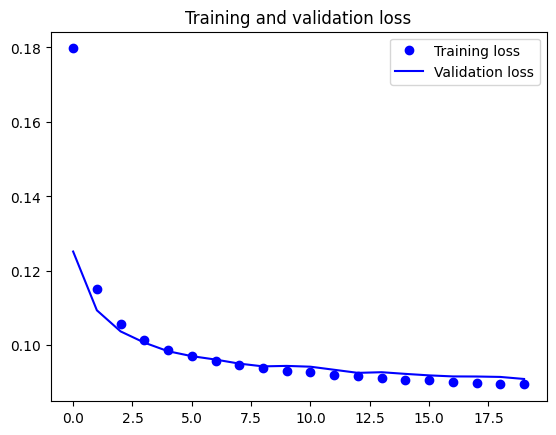

(10000, 28, 28, 1)


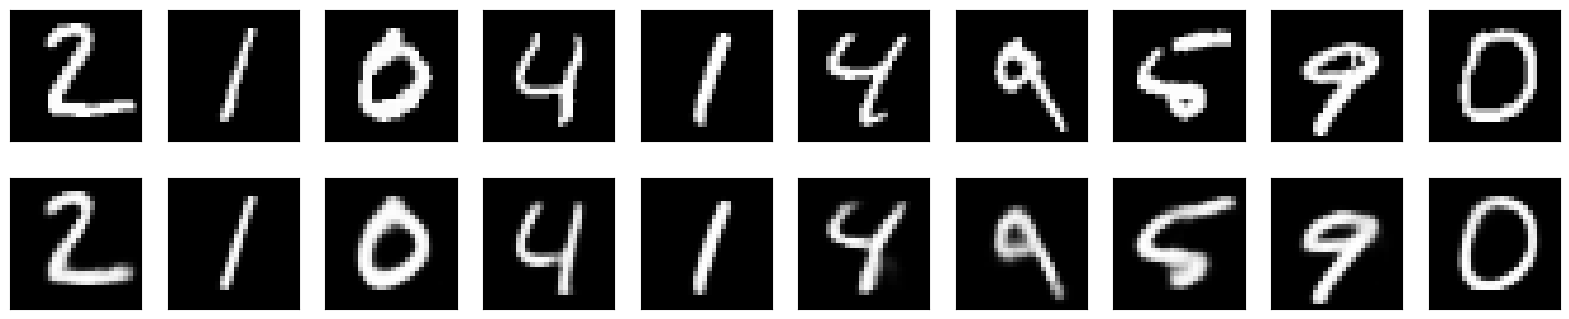

In [ ]:
decoded_imgs = basic.predict(x_test)

decoded_images = (255 * decoded_imgs).astype(np.uint8)

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epoch)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_images[i].reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Predictions

Load the models if saved in some file...

In [7]:
from tensorflow.keras.models import load_model

# Specify the path to your saved Keras model file
path_to_mnist_models = 'drive/MyDrive/MNIST/models/'
basic = load_model(path_to_mnist_models + 'autoencoder_model_corr_30.keras')
encoder_model = load_model(path_to_mnist_models + 'encoder_model_corr_30.keras')
decoder_model = load_model(path_to_mnist_models + 'decoder_model_corr_30.keras')

# Now, you can use 'basic,encoder_model,decoder_model' to make predictions or perform other tasks.


In [8]:
encoded_images = encoder_model.predict(x_train)
valid_images = encoder_model.predict(x_valid)

query_images = encoder_model.predict(test_images)
query_images = (query_images * 255).astype(np.uint8)

print(query_images.shape)
print(encoded_images.shape)
print(valid_images.shape)

# Concatenate the encoded representations
concatenated_encoded_images = np.concatenate([encoded_images, valid_images], axis=0)
concatenated_encoded_images = (concatenated_encoded_images * 255).astype(np.uint8)


print(concatenated_encoded_images.shape)



313/313 [==============================] - 5s 16ms/step
(10000, 30)
(48000, 30)
(12000, 30)
(60000, 30)


# Create output file

In [14]:
import numpy as np
import struct

# output_queryset_path

# Get the shape of the dataset
# print(concatenated_encoded_images.shape)
num_images, num_columns = query_images.shape
num_rows = 1
print(num_images, num_columns)


def output_binary_file(path, data, num_images, num_rows, num_columns):
    # Write the binary dataset file
    with open(path, 'wb') as f:
        # Write the magic number (32) as a 32-bit integer
        f.write(struct.pack('>I', 32))

        # Write the number of images, rows, and columns as 32-bit integers
        f.write(struct.pack('>III', num_images, num_rows, num_columns))
        it = 0
        # Iterate through each image in the dataset
        for image in data:

            # Flatten the image and write each pixel as a single byte
            f.write(image.flatten().tobytes())
            if (it == 0):
                print(image)
            it += 1
            # print(image.flatten().tobytes())
    read_images = np.empty((num_images, num_columns), dtype=np.uint8)
    with open(path, 'rb') as f:
        # Read the magic number (32) as a 32-bit integer
        magic_number = struct.unpack('>I', f.read(4))[0]

        # Read the number of images, rows, and columns as 32-bit integers
        num_images, num_rows, num_columns = struct.unpack('>III', f.read(12))

        # Iterate through each image in the dataset
        for i in range(len(data)):
            # Read each pixel as a single byte and reshape to the original image shape
            image_data = struct.unpack('B' * num_columns, f.read(num_columns))
            read_images[i] = np.array(image_data, dtype=np.uint8)
            if (i == 0):
                print(read_images[i])
                flattened_numbers = np.frombuffer(read_images[i], dtype=np.uint8)
                print(flattened_numbers)

    # Reshape the read data to the original shape of the images
    read_images = read_images.reshape((num_images, num_rows, num_columns))
    print(read_images.shape)

output_binary_file(output_queryset_path, query_images, num_images, num_rows, num_columns)

print()

num_images, num_columns = concatenated_encoded_images.shape
num_rows = 1
print(num_images, num_columns)

output_binary_file(output_dataset_path, concatenated_encoded_images, num_images, num_rows, num_columns)

10000 30
[  0 123   0 203  19   0  88   0  63   0   0   0 110   0   0 224  11   0
 245  44   0   0   0   0   0   0 133   0   0   0]
[  0 123   0 203  19   0  88   0  63   0   0   0 110   0   0 224  11   0
 245  44   0   0   0   0   0   0 133   0   0   0]
[  0 123   0 203  19   0  88   0  63   0   0   0 110   0   0 224  11   0
 245  44   0   0   0   0   0   0 133   0   0   0]
(10000, 1, 30)

60000 30
[  0 183   0  12 192   0  22   0 176   0   0   0 244   0   0  65  61   0
 209 245   0   0   0   0   0   0 107   0   0   0]
[  0 183   0  12 192   0  22   0 176   0   0   0 244   0   0  65  61   0
 209 245   0   0   0   0   0   0 107   0   0   0]
[  0 183   0  12 192   0  22   0 176   0   0   0 244   0   0  65  61   0
 209 245   0   0   0   0   0   0 107   0   0   0]
(60000, 1, 30)
